
# Diffusion Foundations — Autoencoders from Scratch (Pure PyTorch)

> Why start here? Diffusion models often learn in a latent space. Well-built **autoencoders** teach us how to compress images into latents and decode them back — a core mental model before VAEs and then diffusion in latent space.



## How to use this notebook
- Execute cell-by-cell. Tweak knobs. Break things (safely) and fix them.
- Each code block is followed by short notes explaining the *why*.
- We'll start tiny, then layer on ideas:
  1. Setup & utilities  
  2. A **Minimal Linear Autoencoder** (vectorized images)  
  3. A **Convolutional Autoencoder** (spatially-aware)  
  4. A **Denoising Autoencoder** (noise in, clean out)  
  5. **Latent space** peeks (tiny traversals)  
  6. Save/Load & next steps towards VAEs → Diffusion


## 0) Setup & Utilities

In [2]:

# If you don't have these, uncomment the installs (when running locally).
# %pip install torch torchvision matplotlib --quiet

import math, os, random, time, sys
from dataclasses import dataclass
from typing import Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset, Dataset

try:
    from torchvision import datasets, transforms, utils as vutils
    HAS_TORCHVISION = True
except Exception as e:
    HAS_TORCHVISION = False
    print("torchvision not available; we'll use a synthetic fallback. Error:", e)

import matplotlib.pyplot as plt

In [3]:
def pick_device() -> torch.device:
    if torch.cuda.is_available():
        return torch.device("cuda")
    if hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
        return torch.device("mps")
    return torch.device("cpu")

DEVICE = pick_device()
print("Using device:", DEVICE)

def set_seed(seed: int = 42):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.use_deterministic_algorithms(False)

set_seed(42)


Using device: mps


In [4]:
def show_images(img_tensor: torch.Tensor, nrow: int = 8, title: str = None):
    """img_tensor: (B, C, H, W) in [0,1]"""
    grid = vutils.make_grid(img_tensor, nrow=nrow, normalize=False, padding=2) if HAS_TORCHVISION else img_tensor
    plt.figure(figsize=(8, 8))
    if grid.ndim == 3:
        plt.imshow(grid.permute(1,2,0).cpu().numpy(), interpolation="nearest")
    else:
        # Fallback: assume single image HxW
        plt.imshow(img_tensor.cpu().numpy(), interpolation="nearest")
    plt.axis("off")
    if title:
        plt.title(title)
    plt.show()



**Notes:**  
- We pick `cuda` → `mps` (Apple Silicon) → `cpu`.  
- `show_images` uses `torchvision.utils.make_grid` if available. If torchvision is missing, we still avoid breaking.


## 1) Data: MNIST (with safe fallbacks)

100.0%
100.0%
100.0%
100.0%


Batch: torch.Size([128, 1, 28, 28]) 0.0 1.0


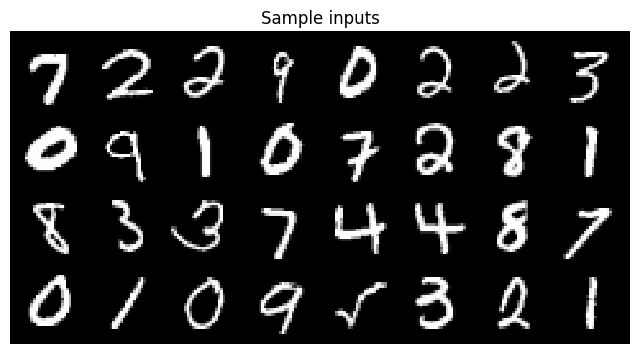

In [5]:

IMG_SIZE = 28  # MNIST
BATCH_SIZE = 128
LIMIT = 10_000   # feel free to shrink or grow this subset for speed
NUM_WORKERS = 2 if sys.platform != "win32" else 0

# We'll try: MNIST → FakeData → synthetic Gaussian blobs
class TinySynthetic(Dataset):
    def __init__(self, n=5000, img_size=28):
        self.n = n
        self.img_size = img_size
    def __len__(self): return self.n
    def __getitem__(self, idx: int):
        # Random smooth blobs as grayscale "images"
        img = torch.randn(1, self.img_size, self.img_size).float()
        img = (img - img.min()) / (img.max() - img.min() + 1e-8)  # [0,1]
        return img, 0

if HAS_TORCHVISION:
    transform = transforms.Compose([
        transforms.ToTensor(),  # [0,1]
    ])
    try:
        train_full = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
        test_set  = datasets.MNIST(root="./data", train=False, download=True, transform=transform)
        idx = torch.randperm(len(train_full))[:LIMIT]
        train_set = Subset(train_full, idx.tolist())
    except Exception as e:
        print("MNIST download failed, switching to FakeData. Error:", e)
        try:
            train_set = datasets.FakeData(size=LIMIT, image_size=(1, IMG_SIZE, IMG_SIZE), transform=transform)
            test_set  = datasets.FakeData(size=2000, image_size=(1, IMG_SIZE, IMG_SIZE), transform=transform)
        except Exception as e2:
            print("FakeData unavailable, switching to synthetic fallback. Error:", e2)
            train_set = TinySynthetic(n=LIMIT, img_size=IMG_SIZE)
            test_set  = TinySynthetic(n=2000, img_size=IMG_SIZE)
else:
    train_set = TinySynthetic(n=LIMIT, img_size=IMG_SIZE)
    test_set  = TinySynthetic(n=2000, img_size=IMG_SIZE)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, drop_last=True)
test_loader  = DataLoader(test_set,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, drop_last=False)

# Peek at a batch
xb, yb = next(iter(train_loader))
print("Batch:", xb.shape, xb.min().item(), xb.max().item())
if HAS_TORCHVISION:
    show_images(xb[:32], nrow=8, title="Sample inputs")



**Notes:**  
- We use MNIST by default; if it fails (offline runs), we fallback to `FakeData`, else a tiny synthetic dataset.  
- Images are **grayscale 28×28** in `[0,1]`.


## 2) Minimal Linear Autoencoder (vectorized images)

In [15]:

@dataclass
class AEConfig:
    input_dim: int = IMG_SIZE * IMG_SIZE   # 784 for 28x28 grayscale
    hidden_dim: int = 256
    latent_dim: int = 2
    lr: float = 1e-3
    epochs: int = 10

class LinearAE(nn.Module):
    def __init__(self, cfg: AEConfig):
        super().__init__()
        self.cfg = cfg
        self.encoder = nn.Sequential(
            nn.Linear(cfg.input_dim, cfg.hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(cfg.hidden_dim, cfg.latent_dim),
        )
        self.decoder = nn.Sequential(
            nn.Linear(cfg.latent_dim, cfg.hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(cfg.hidden_dim, cfg.input_dim),
            nn.Sigmoid(),   # map to [0,1] since inputs are [0,1]
        )

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        # x: (B, 1, 28, 28) -> flatten to (B, 784)
        x = x.view(x.size(0), -1)
        z = self.encode(x)
        xr = self.decode(z)
        xr = xr.view(-1, 1, IMG_SIZE, IMG_SIZE)
        return xr, z


Epoch 01/10 | train 0.0844 | test 0.0633
Epoch 02/10 | train 0.0593 | test 0.0560
Epoch 03/10 | train 0.0551 | test 0.0539
Epoch 04/10 | train 0.0535 | test 0.0525
Epoch 05/10 | train 0.0524 | test 0.0516
Epoch 06/10 | train 0.0517 | test 0.0510
Epoch 07/10 | train 0.0512 | test 0.0507
Epoch 08/10 | train 0.0507 | test 0.0501
Epoch 09/10 | train 0.0502 | test 0.0495
Epoch 10/10 | train 0.0496 | test 0.0490


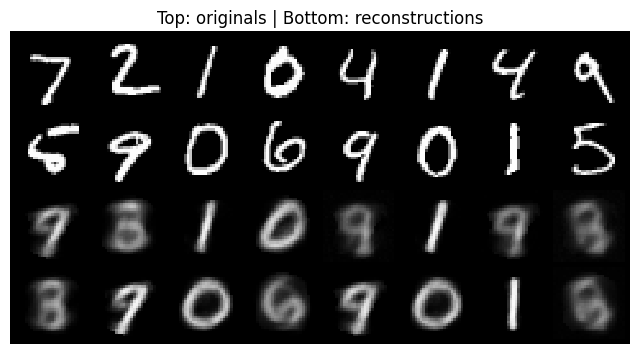

In [16]:
def train_autoencoder(model, train_loader, test_loader, cfg: AEConfig, device=DEVICE):
    model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=cfg.lr)
    loss_fn = nn.MSELoss()
    history = {"train_loss": [], "test_loss": []}

    for epoch in range(cfg.epochs):
        model.train()
        running = 0.0
        for xb, _ in train_loader:
            xb = xb.to(device)
            xr, z = model(xb)
            loss = loss_fn(xr, xb)

            opt.zero_grad(set_to_none=True)
            loss.backward()
            opt.step()
            running += loss.item()

        train_loss = running / max(1, len(train_loader))
        history["train_loss"].append(train_loss)

        # Eval
        model.eval()
        running = 0.0
        with torch.no_grad():
            for xb, _ in test_loader:
                xb = xb.to(device)
                xr, _ = model(xb)
                loss = loss_fn(xr, xb)
                running += loss.item()
        test_loss = running / max(1, len(test_loader))
        history["test_loss"].append(test_loss)

        print(f"Epoch {epoch+1:02d}/{cfg.epochs} | train {train_loss:.4f} | test {test_loss:.4f}")

    return history

lin_cfg = AEConfig()
lin_ae = LinearAE(lin_cfg)

# Train briefly (increase epochs later as you wish)
hist = train_autoencoder(lin_ae, train_loader, test_loader, lin_cfg, DEVICE)

# Visualize reconstructions
lin_ae.eval()
with torch.no_grad():
    xb, _ = next(iter(test_loader))
    xb = xb.to(DEVICE)[:16]
    xr, z = lin_ae(xb)
if HAS_TORCHVISION:
    show_images(torch.cat([xb.cpu(), xr.cpu()], dim=0), nrow=8, title="Top: originals | Bottom: reconstructions")



**Notes:**  
- We **flatten** images to vectors → lose spatial structure but it's the simplest start.  
- Loss is **MSE** between input and reconstruction.  
- Decoder ends with `Sigmoid()` to match input range `[0,1]`.  
- Try changing `latent_dim` to `2` and watch recon quality drop — but you'll be able to *plot* the latents.


## 3) Convolutional Autoencoder (spatial inductive bias)

Epoch 01/10 | train 0.1460 | test 0.0714
Epoch 02/10 | train 0.0685 | test 0.0654
Epoch 03/10 | train 0.0564 | test 0.0446
Epoch 04/10 | train 0.0382 | test 0.0319
Epoch 05/10 | train 0.0296 | test 0.0264
Epoch 06/10 | train 0.0254 | test 0.0233
Epoch 07/10 | train 0.0230 | test 0.0217
Epoch 08/10 | train 0.0215 | test 0.0204
Epoch 09/10 | train 0.0205 | test 0.0196
Epoch 10/10 | train 0.0198 | test 0.0190


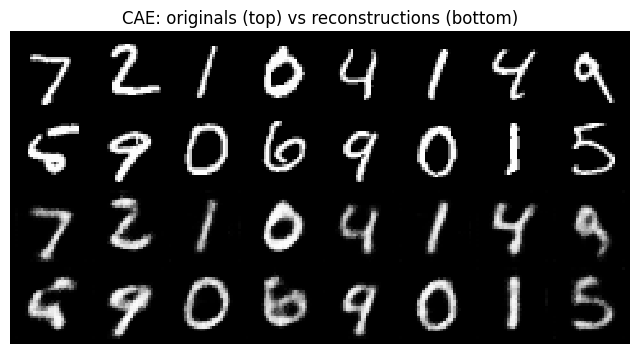

In [10]:

@dataclass
class CAEConfig:
    latent_dim: int = 16
    lr: float = 1e-3
    epochs: int = 10

class ConvAE(nn.Module):
    def __init__(self, cfg: CAEConfig):
        super().__init__()
        self.cfg = cfg
        # Encoder: (B,1,28,28) -> (B,8,14,14) -> (B,16,7,7) -> flatten -> latent
        self.enc_conv = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, stride=2, padding=1),  # 28->14
            nn.ReLU(inplace=True),
            nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1), # 14->7
            nn.ReLU(inplace=True),
        )
        self.enc_fc = nn.Linear(16*7*7, cfg.latent_dim)

        # Decoder: latent -> (B,16,7,7) -> deconv to (B,1,28,28)
        self.dec_fc = nn.Linear(cfg.latent_dim, 16*7*7)
        self.dec_deconv = nn.Sequential(
            nn.ConvTranspose2d(16, 8, kernel_size=4, stride=2, padding=1),  # 7->14
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(8, 1, kernel_size=4, stride=2, padding=1),  # 14->28
            nn.Sigmoid(),
        )

    def encode(self, x):
        h = self.enc_conv(x)
        h = h.view(x.size(0), -1)
        z = self.enc_fc(h)
        return z

    def decode(self, z):
        h = self.dec_fc(z)
        h = h.view(z.size(0), 16, 7, 7)
        xrec = self.dec_deconv(h)
        return xrec

    def forward(self, x):
        z = self.encode(x)
        xr = self.decode(z)
        return xr, z

def train_cae(model, train_loader, test_loader, cfg: CAEConfig, device=DEVICE):
    model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=cfg.lr)
    loss_fn = nn.MSELoss()
    history = {"train_loss": [], "test_loss": []}

    for epoch in range(cfg.epochs):
        model.train()
        running = 0.0
        for xb, _ in train_loader:
            xb = xb.to(device)
            xr, z = model(xb)
            loss = loss_fn(xr, xb)

            opt.zero_grad(set_to_none=True)
            loss.backward()
            opt.step()
            running += loss.item()

        train_loss = running / max(1, len(train_loader))
        history["train_loss"].append(train_loss)

        model.eval()
        running = 0.0
        with torch.no_grad():
            for xb, _ in test_loader:
                xb = xb.to(device)
                xr, _ = model(xb)
                loss = loss_fn(xr, xb)
                running += loss.item()
        test_loss = running / max(1, len(test_loader))
        history["test_loss"].append(test_loss)

        print(f"Epoch {epoch+1:02d}/{cfg.epochs} | train {train_loss:.4f} | test {test_loss:.4f}")

    return history

cae_cfg = CAEConfig()
cae = ConvAE(cae_cfg)
hist2 = train_cae(cae, train_loader, test_loader, cae_cfg, DEVICE)

# Visualize
cae.eval()
with torch.no_grad():
    xb, _ = next(iter(test_loader))
    xb = xb.to(DEVICE)[:16]
    xr, z = cae(xb)
if HAS_TORCHVISION:
    show_images(torch.cat([xb.cpu(), xr.cpu()], dim=0), nrow=8, title="CAE: originals (top) vs reconstructions (bottom)")



**Notes:**  
- Convolutions capture **local structure** and reuse weights spatially → better reconstructions at similar parameter budgets.  
- `ConvTranspose2d` upsamples. Stride and padding are chosen to match sizes exactly (28→14→7 then back).  
- Try increasing `latent_dim` to see capacity effects.


## 4) Denoising Autoencoder (noise in, clean out)

Epoch 01/10 | DAE train 0.1175 | test 0.0709
Epoch 02/10 | DAE train 0.0695 | test 0.0679
Epoch 03/10 | DAE train 0.0633 | test 0.0573
Epoch 04/10 | DAE train 0.0524 | test 0.0487
Epoch 05/10 | DAE train 0.0448 | test 0.0391
Epoch 06/10 | DAE train 0.0358 | test 0.0326
Epoch 07/10 | DAE train 0.0315 | test 0.0294
Epoch 08/10 | DAE train 0.0289 | test 0.0271
Epoch 09/10 | DAE train 0.0270 | test 0.0256
Epoch 10/10 | DAE train 0.0256 | test 0.0245


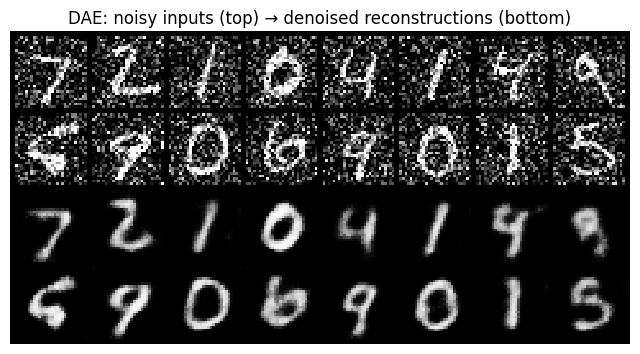

In [13]:

@dataclass
class DAEConfig:
    latent_dim: int = 16
    noise_std: float = 0.3
    lr: float = 1e-3
    epochs: int = 10

class DenoisingConvAE(ConvAE):
    pass  # we reuse the architecture; only training changes

def add_noise(x, std=0.3):
    return (x + std * torch.randn_like(x)).clamp(0.0, 1.0)

def train_dae(model, train_loader, test_loader, cfg: DAEConfig, device=DEVICE):
    model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=cfg.lr)
    loss_fn = nn.MSELoss()

    for epoch in range(cfg.epochs):
        model.train()
        running = 0.0
        for xb, _ in train_loader:
            xb = xb.to(device)
            x_noisy = add_noise(xb, cfg.noise_std)
            xr, _ = model(x_noisy)   # predict clean from noisy
            loss = loss_fn(xr, xb)

            opt.zero_grad(set_to_none=True)
            loss.backward()
            opt.step()
            running += loss.item()

        train_loss = running / max(1, len(train_loader))

        # Eval: use noisy inputs but measure against clean targets
        model.eval()
        running = 0.0
        with torch.no_grad():
            for xb, _ in test_loader:
                xb = xb.to(device)
                x_noisy = add_noise(xb, cfg.noise_std)
                xr, _ = model(x_noisy)
                loss = loss_fn(xr, xb)
                running += loss.item()
        test_loss = running / max(1, len(test_loader))
        print(f"Epoch {epoch+1:02d}/{cfg.epochs} | DAE train {train_loss:.4f} | test {test_loss:.4f}")

dae_cfg = DAEConfig(latent_dim=16, noise_std=0.4, epochs=10)
dae = DenoisingConvAE(CAEConfig(latent_dim=dae_cfg.latent_dim))
train_dae(dae, train_loader, test_loader, dae_cfg, DEVICE)

# Visualize
dae.eval()
with torch.no_grad():
    xb, _ = next(iter(test_loader))
    xb = xb.to(DEVICE)[:16]
    x_noisy = add_noise(xb, dae_cfg.noise_std)
    xr, _ = dae(x_noisy)
if HAS_TORCHVISION:
    show_images(torch.cat([x_noisy.cpu(), xr.cpu()], dim=0), nrow=8, title="DAE: noisy inputs (top) → denoised reconstructions (bottom)")



**Notes:**  
- This is our **first step toward diffusion-y thinking**: learn to *remove* noise.  
- Unlike diffusion, we're using a single-step denoising; diffusion uses multi-step noise schedules & noise-prediction training. We'll get there.


## 5) Peek at Latents (optional mini-visuals)

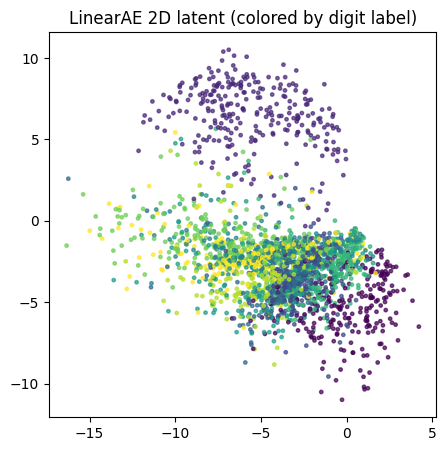

In [17]:

# Set latent_dim=2 in LinearAE or CAE to try this.
def project_with_model(model, loader, max_batches=10):
    Z, Y = [], []
    model.eval()
    with torch.no_grad():
        for i, (xb, yb) in enumerate(loader):
            xb = xb.to(DEVICE)
            if hasattr(model, "encode"):
                if isinstance(model, LinearAE):
                    z = model.encode(xb.view(xb.size(0), -1))
                else:
                    z = model.encode(xb)
            else:
                xr, z = model(xb)
            Z.append(z.cpu())
            Y.append(yb)
            if i+1 >= max_batches: break
    return torch.cat(Z,0), torch.cat(Y,0)

# Example (will only look nice if latent_dim==2)
if lin_ae.cfg.latent_dim == 2:
    Z, Y = project_with_model(lin_ae, test_loader, max_batches=20)
    plt.figure(figsize=(5,5))
    plt.scatter(Z[:,0], Z[:,1], c=Y.numpy(), s=6, alpha=0.7)
    plt.title("LinearAE 2D latent (colored by digit label)")
    plt.show()
else:
    print("Tip: set latent_dim=2 and rerun training to visualize a 2D latent.")



**Notes:**  
- With only 2 latent dims, you'll see clusters and overlaps → intuition for **capacity vs disentanglement**.  
- Later, VAEs will give us probabilistic latents that are easier to traverse.


## 6) Save & Load (for reuse later)

In [18]:

os.makedirs("checkpoints", exist_ok=True)
torch.save(lin_ae.state_dict(), "checkpoints/linear_ae.pt")
torch.save(cae.state_dict(),     "checkpoints/conv_ae.pt")
torch.save(dae.state_dict(),     "checkpoints/denoise_conv_ae.pt")

# Example load:
lin_ae_loaded = LinearAE(lin_cfg)
lin_ae_loaded.load_state_dict(torch.load("checkpoints/linear_ae.pt", map_location=DEVICE))
lin_ae_loaded.to(DEVICE).eval()
print("Loaded linear AE OK")


Loaded linear AE OK



**Notes:**  
- We'll reuse encoders as **feature extractors** and decoders as **generators** in later lessons (VAE → Diffusion in latent space).
